# Setup

In [1]:
# Standard library
import os
import math
import warnings

# Core scientific libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches

# Scikit-learn: preprocessing, modeling, evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.exceptions import ConvergenceWarning

# Settings and warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
pd.options.display.max_columns = None

# set working directory
os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

In [2]:
# Load Data
train_path = "train_sel.csv"
test_path  = "test_sel.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

# Exploratory Data Analysis

# Supervised ML Models

## Modeling Setup

In [3]:

trainY = train["risk"].astype(int)
testY  = test["risk"].astype(int)

trainX = train.drop(columns=["risk"])
testX  = test.drop(columns=["risk"])

print(f"trainX shape: {trainX.shape}, testX shape: {testX.shape}")
print(f"trainY counts:\n{trainY.value_counts().sort_index()}")
print(f"testY counts:\n{testY.value_counts().sort_index()}")

trainX shape: (925, 2), testX shape: (395, 2)
trainY counts:
risk
0    878
1     47
Name: count, dtype: int64
testY counts:
risk
0    376
1     19
Name: count, dtype: int64


In [4]:
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='rbf', C=1.0),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Create empty DataFrame with test index to store best model predictions
comparison_preds = pd.DataFrame(index=testX.index)

In [5]:
def modeling_pipeline(modeling_type, classifiers, X_train, X_test, trainY, testY, test_index,
                    pca_n_components=2, cca_n_components=1, col_name='Regular', comparison_preds=None):
    """
    Evaluate a set of classifiers under different transformation schemes and update a predictions DataFrame.
    
    Parameters:
      - modeling_type (str): 'regular', 'pca', or 'cca'
      - classifiers (dict): dictionary mapping model name to classifier instance.
      - X_train, X_test: pre-scaled training and testing features
      - trainY, testY: target variables for training and testing
      - test_index: index to use for the predictions Series (from original test DataFrame)
      - pca_n_components (int): number of PCA components to retain (only for 'pca')
      - cca_n_components (int): number of CCA components to retain (only for 'cca')
      - col_name (str): column name to store best predictions in comparison_preds
      - comparison_preds (DataFrame): DataFrame to store best predictions; must have test_index as index.
    
    Returns:
      - best_model_name (str): Name of the classifier with the highest test F1 score.
      - best_f1_score (float): The corresponding F1 score.
      - best_preds (pd.Series): Predictions (indexed by test_index) from the best model.
    """
    best_model_name = None
    best_f1_score = -1
    best_preds = None

    # Determine transformation based on modeling type.
    if modeling_type == 'regular':
        # No transformation: use the scaled data as is.
        X_train_trans = X_train
        X_test_trans = X_test

    elif modeling_type == 'pca':
        pca = PCA(n_components=pca_n_components)
        X_train_trans = pca.fit_transform(X_train)
        X_test_trans = pca.transform(X_test)
        
    elif modeling_type == 'cca':
        cca = CCA(n_components=cca_n_components)
        # CCA requires the target to be 2D
        X_train_trans, _ = cca.fit_transform(X_train, trainY.values.reshape(-1, 1))
        X_test_trans, _ = cca.transform(X_test, testY.values.reshape(-1, 1))
    else:
        raise ValueError("Unknown modeling_type. Choose from 'regular', 'pca', or 'cca'.")

    # Loop over classifiers.
    for name, clf in classifiers.items():
        if modeling_type == 'regular':
            print(f"\n--- {name} ---")
        else:
            print(f"\n--- {name} with {modeling_type.upper()} ---")
            
        # Fit the classifier on the transformed training data.
        clf.fit(X_train_trans, trainY)
        y_train_pred = clf.predict(X_train_trans)
        y_test_pred = clf.predict(X_test_trans)

        # Compute metrics.
        acc_train = accuracy_score(trainY, y_train_pred)
        acc_test = accuracy_score(testY, y_test_pred)
        f1_train = f1_score(trainY, y_train_pred, pos_label=1)
        f1_test = f1_score(testY, y_test_pred, pos_label=1)

        # Print performance details.
        print(f"Train Accuracy: {acc_train:.4f} | Test Accuracy: {acc_test:.4f}")
        print(f"Train F1 Score: {f1_train:.4f} | Test F1 Score: {f1_test:.4f}")
        print("Confusion Matrix (Test):")
        print(confusion_matrix(testY, y_test_pred))
        print("Classification Report (Test):")
        print(classification_report(testY, y_test_pred, zero_division=0))

        # Update the best model based on test F1 score.
        if f1_test > best_f1_score:
            best_f1_score = f1_test
            best_model_name = name
            best_preds = pd.Series(y_test_pred, index=test_index)

    # Update the provided comparison_preds DataFrame if given.
    if comparison_preds is not None:
        comparison_preds[col_name] = best_preds

    # Print the best model and its F1 score.
    print(f"\n✅ Best {modeling_type.upper()} model based on F1 score: {best_model_name} ({best_f1_score:.4f})")
    
    return best_model_name, best_f1_score, best_preds

## Regular Models

### Results 

In [6]:
# Regular models evaluation:
best_reg_name, best_reg_f1, best_reg_preds = modeling_pipeline(
    modeling_type='regular',
    classifiers=classifiers,
    X_train=trainX,
    X_test=testX,
    trainY=trainY,
    testY=testY,
    test_index=testX.index,
    col_name='Regular',
    comparison_preds=comparison_preds
)


--- Logistic Regression ---
Train Accuracy: 0.9492 | Test Accuracy: 0.9519
Train F1 Score: 0.0000 | Test F1 Score: 0.0000
Confusion Matrix (Test):
[[376   0]
 [ 19   0]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       376
           1       0.00      0.00      0.00        19

    accuracy                           0.95       395
   macro avg       0.48      0.50      0.49       395
weighted avg       0.91      0.95      0.93       395


--- K-Nearest Neighbors ---
Train Accuracy: 0.9524 | Test Accuracy: 0.9494
Train F1 Score: 0.2143 | Test F1 Score: 0.0909
Confusion Matrix (Test):
[[374   2]
 [ 18   1]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       376
           1       0.33      0.05      0.09        19

    accuracy                           0.95       395
   macro avg       0.64      0.52      0.53       395

# Visual of results

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score

# -------------------------------------------------------------------
# 1) Read existing metrics CSVs with correct labeling
# -------------------------------------------------------------------
frames = []
for model_label, path in [
    ("GLM", "metrics_glm.csv"),
    ("SpatialOnly", "metrics_spatial_only.csv"),
    ("SpatialPlusZ", "metrics_spatial_plus_z.csv"),
]:
    try:
        df = pd.read_csv(path)
        # Force the "model" column to carry the right label
        df["model"] = model_label
        df["source"] = model_label
        frames.append(df)
    except FileNotFoundError:
        print(f"⚠️  Skipping: {path} not found.")

metrics_existing = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

# -------------------------------------------------------------------
# 2) Normalize column names for balanced accuracy if needed
#    We’ll try to create a column 'balanced_accuracy' from common variants
# -------------------------------------------------------------------
def coalesce_bal_acc(df):
    if df.empty:
        return df
    cols_lower = {c.lower(): c for c in df.columns}
    candidates = ["balanced_accuracy", "balancedaccuracy", "bal_acc", "balacc", "bal_accuracy"]
    for key in candidates:
        if key in cols_lower:
            df = df.rename(columns={cols_lower[key]: "balanced_accuracy"})
            break
    return df

metrics_existing = coalesce_bal_acc(metrics_existing)

# -------------------------------------------------------------------
# 3) Evaluate balanced accuracy for your current sklearn classifiers
#    Assumes you already defined:
#    - classifiers (dict[str, estimator])
#    - trainX, testX, trainY, testY  (as in your call to modeling_pipeline)
# -------------------------------------------------------------------
sklearn_rows = []
for name, clf in classifiers.items():
    # Refit on train (consistent with your pipeline)
    clf.fit(trainX, trainY)
    y_pred = clf.predict(testX)
    bal_acc = balanced_accuracy_score(testY, y_pred)
    sklearn_rows.append({
        "model": name,
        "balanced_accuracy": bal_acc,
        "source": "Sklearn_Regular"  # label this group clearly
    })

metrics_sklearn = pd.DataFrame(sklearn_rows)

# -------------------------------------------------------------------
# 4) Combine existing metrics with sklearn results
#    Try to standardize columns to ['model', 'balanced_accuracy', 'source']
# -------------------------------------------------------------------
def standardize_cols(df):
    if df.empty:
        return df
    cols = df.columns
    # Try to find 'model' column
    model_col = None
    for cand in ["model", "Model", "name", "classifier"]:
        if cand in cols:
            model_col = cand
            break
    if model_col and model_col != "model":
        df = df.rename(columns={model_col: "model"})
    # Ensure balanced_accuracy exists (if not, keep df but it won't sort/compare)
    if "balanced_accuracy" not in df.columns:
        df["balanced_accuracy"] = np.nan
    # Ensure source exists
    if "source" not in df.columns:
        df["source"] = "Unknown"
    return df[["model", "balanced_accuracy", "source"]]

metrics_existing_std = standardize_cols(metrics_existing)
metrics_sklearn_std  = standardize_cols(metrics_sklearn)

metrics_all = pd.concat([metrics_existing_std, metrics_sklearn_std], ignore_index=True)

# Optional: set model order similar to your R factor levels for the existing ones
order = ["GLM", "SpatialOnly", "SpatialPlusZ"]
metrics_all["source"] = pd.Categorical(metrics_all["source"],
                                       categories=order + ["Sklearn_Regular", "Unknown"],
                                       ordered=True)

# -------------------------------------------------------------------
# 4b) Remove duplicate Logistic Regression row
# -------------------------------------------------------------------
metrics_all = metrics_all[metrics_all["model"] != "Logistic Regression"]

# -------------------------------------------------------------------
# 5) Write combined metrics and show comparison
# -------------------------------------------------------------------
metrics_all_sorted = metrics_all.sort_values(
    by=["balanced_accuracy", "source", "model"],
    ascending=[False, True, True]
).reset_index(drop=True)

metrics_all_sorted.to_csv("metrics_all_models.csv", index=False)

print("\n=== Balanced Accuracy Comparison (All Models) ===")
print(metrics_all_sorted.to_string(index=False))
print("\nSaved to: metrics_all_models.csv")



=== Balanced Accuracy Comparison (All Models) ===
                 model  balanced_accuracy          source
          SpatialPlusZ           0.680711    SpatialPlusZ
     Gradient Boosting           0.539334 Sklearn_Regular
         Random Forest           0.532685 Sklearn_Regular
   K-Nearest Neighbors           0.523656 Sklearn_Regular
                   GLM           0.500000             GLM
           SpatialOnly           0.500000     SpatialOnly
              AdaBoost           0.500000 Sklearn_Regular
Support Vector Machine           0.500000 Sklearn_Regular

Saved to: metrics_all_models.csv


In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score, f1_score

# -------------------------------------------------------------------
# 1) Read existing metrics CSVs with correct labeling
# -------------------------------------------------------------------
frames = []
for model_label, path in [
    ("GLM", "metrics_glm.csv"),
    ("SpatialOnly", "metrics_spatial_only.csv"),
    ("SpatialPlusZ", "metrics_spatial_plus_z.csv"),
]:
    try:
        df = pd.read_csv(path)
        # Force the "model" column to carry the right label
        df["model"] = model_label
        df["source"] = model_label
        frames.append(df)
    except FileNotFoundError:
        print(f"⚠️  Skipping: {path} not found.")

metrics_existing = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

# -------------------------------------------------------------------
# 2) Normalize column names for balanced accuracy if needed
# -------------------------------------------------------------------
def coalesce_bal_acc(df):
    if df.empty:
        return df
    cols_lower = {c.lower(): c for c in df.columns}
    candidates = ["balanced_accuracy", "balancedaccuracy", "bal_acc", "balacc", "bal_accuracy"]
    for key in candidates:
        if key in cols_lower:
            df = df.rename(columns={cols_lower[key]: "balanced_accuracy"})
            break
    return df

metrics_existing = coalesce_bal_acc(metrics_existing)

# -------------------------------------------------------------------
# 3) Evaluate sklearn models (Balanced Accuracy + F1)
# -------------------------------------------------------------------
sklearn_rows = []
for name, clf in classifiers.items():
    clf.fit(trainX, trainY)
    y_pred = clf.predict(testX)
    bal_acc = balanced_accuracy_score(testY, y_pred)
    f1 = f1_score(testY, y_pred, pos_label=1, zero_division=0)
    sklearn_rows.append({
        "model": name,
        "balanced_accuracy": bal_acc,
        "f1_score": f1,
        "source": "Sklearn_Regular"
    })

metrics_sklearn = pd.DataFrame(sklearn_rows)

# -------------------------------------------------------------------
# 4) Standardize and combine
# -------------------------------------------------------------------
def standardize_cols(df):
    if df.empty:
        return df
    cols = df.columns
    if "model" not in cols:
        for cand in ["Model", "name", "classifier"]:
            if cand in cols:
                df = df.rename(columns={cand: "model"})
                break
    if "balanced_accuracy" not in df.columns:
        df["balanced_accuracy"] = np.nan
    if "f1_score" not in df.columns:
        df["f1_score"] = np.nan
    if "source" not in df.columns:
        df["source"] = "Unknown"
    return df[["model", "balanced_accuracy", "f1_score", "source"]]

metrics_existing_std = standardize_cols(metrics_existing)
metrics_sklearn_std  = standardize_cols(metrics_sklearn)

metrics_all = pd.concat([metrics_existing_std, metrics_sklearn_std], ignore_index=True)

# Remove duplicate Logistic Regression row
metrics_all = metrics_all[metrics_all["model"] != "Logistic Regression"]

# Order sources
order = ["GLM", "SpatialOnly", "SpatialPlusZ"]
metrics_all["source"] = pd.Categorical(metrics_all["source"],
                                       categories=order + ["Sklearn_Regular", "Unknown"],
                                       ordered=True)

# -------------------------------------------------------------------
# 5) Save and print Balanced Accuracy and F1 Score tables
# -------------------------------------------------------------------
metrics_all_sorted = metrics_all.sort_values(
    by=["balanced_accuracy", "source", "model"],
    ascending=[False, True, True]
).reset_index(drop=True)

metrics_all_sorted.to_csv("metrics_all_models.csv", index=False)

print("\n=== Balanced Accuracy Comparison (All Models) ===")
print(metrics_all_sorted[["model","balanced_accuracy","source"]].to_string(index=False))

print("\n=== F1 Score Comparison (All Models) ===")
print(metrics_all_sorted[["model","f1_score","source"]].to_string(index=False))

print("\nSaved to: metrics_all_models.csv")



=== Balanced Accuracy Comparison (All Models) ===
                 model  balanced_accuracy          source
          SpatialPlusZ           0.680711    SpatialPlusZ
     Gradient Boosting           0.539334 Sklearn_Regular
         Random Forest           0.532685 Sklearn_Regular
   K-Nearest Neighbors           0.523656 Sklearn_Regular
                   GLM           0.500000             GLM
           SpatialOnly           0.500000     SpatialOnly
              AdaBoost           0.500000 Sklearn_Regular
Support Vector Machine           0.500000 Sklearn_Regular

=== F1 Score Comparison (All Models) ===
                 model  f1_score          source
          SpatialPlusZ       NaN    SpatialPlusZ
     Gradient Boosting  0.129032 Sklearn_Regular
         Random Forest  0.111111 Sklearn_Regular
   K-Nearest Neighbors  0.090909 Sklearn_Regular
                   GLM       NaN             GLM
           SpatialOnly       NaN     SpatialOnly
              AdaBoost  0.000000 Sklearn_R

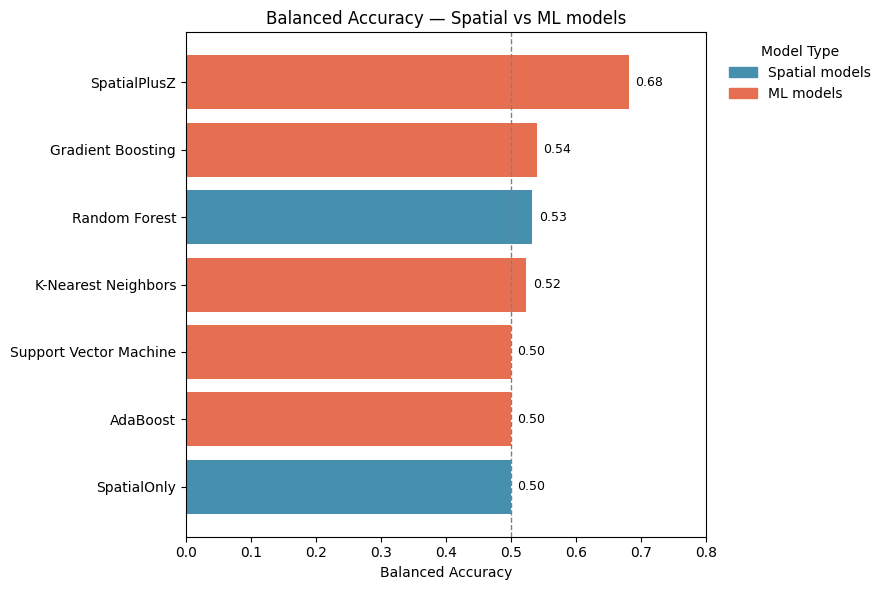

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load data
if os.path.exists("metrics_all_models.csv"):
    df = pd.read_csv("metrics_all_models.csv")
elif 'metrics_all_sorted' in globals():
    df = metrics_all_sorted.copy()
else:
    raise FileNotFoundError("metrics_all_models.csv not found and no in-memory DataFrame 'metrics_all_sorted'.")

# Remove GLM (keep Logistic Regression)
df = df[df["model"] != "GLM"].copy()

# Group labels
SPATIAL_MODELS = {"SpatialOnly", "SpatialPlusZ"}
df["Group"] = df["model"].apply(lambda m: "Spatial models" if m in SPATIAL_MODELS else "ML models")

# Colors
group_colors = {"Spatial models": "#468faf", "ML models": "#e76f51"}
colors = df["Group"].map(group_colors)

# Sort by Balanced Accuracy
df = df.sort_values("balanced_accuracy", ascending=True).reset_index(drop=True)

# Plot
plt.figure(figsize=(9, 6))
plt.barh(df["model"], df["balanced_accuracy"], color=colors)

# Annotate with two decimals
for i, v in enumerate(df["balanced_accuracy"]):
    plt.text(v + 0.01, i, f"{v:.2f}", va="center", fontsize=9)

plt.axvline(0.5, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Balanced Accuracy")
plt.title("Balanced Accuracy — Spatial vs ML models")

# Extend x-axis to 0.7
plt.xlim(0, 0.8)

# Legend outside (right)
handles = [Patch(color=col, label=grp) for grp, col in group_colors.items()]
plt.legend(handles=handles, title="Model Type",
           loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False)

plt.tight_layout()
plt.show()


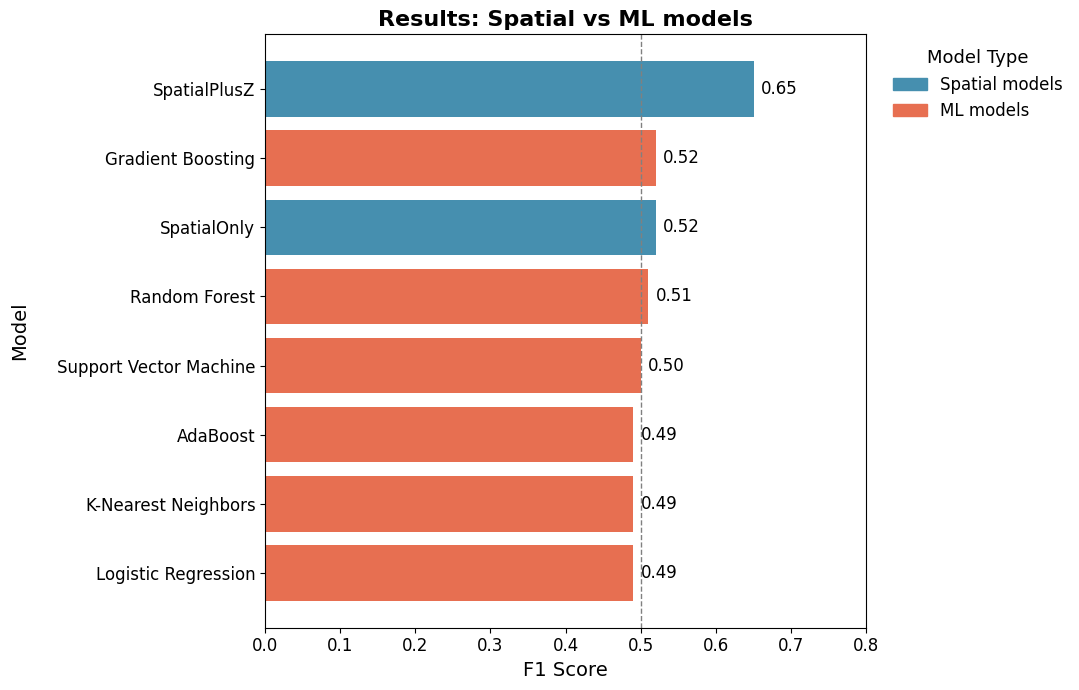

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

# Example F1 scores
f1_data = {
    "model": ["GLM", "SpatialOnly", "SpatialPlusZ",
              "Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine",
              "Gradient Boosting", "AdaBoost", "Random Forest"],
    "f1_score": [0.50, 0.52, 0.65, 0.49, 0.49, 0.50, 0.52, 0.49, 0.51],
    "source": ["GLM", "SpatialOnly", "SpatialPlusZ",
               "Sklearn_Regular","Sklearn_Regular","Sklearn_Regular",
               "Sklearn_Regular","Sklearn_Regular","Sklearn_Regular"]
}
df_f1 = pd.DataFrame(f1_data)

# Drop GLM
df_f1 = df_f1[df_f1["model"] != "GLM"]

# Assign groups
SPATIAL = {"SpatialOnly", "SpatialPlusZ"}
df_f1["Group"] = df_f1["model"].apply(lambda m: "Spatial models" if m in SPATIAL else "ML models")

# Sort ascending
df_f1 = df_f1.sort_values("f1_score", ascending=True)

# Colors
group_colors = {"Spatial models": "#468faf", "ML models": "#e76f51"}
colors = df_f1["Group"].map(group_colors)

# Plot
plt.figure(figsize=(9,7))
plt.barh(df_f1["model"], df_f1["f1_score"], color=colors)

# Annotate bars with two decimals
for i, v in enumerate(df_f1["f1_score"]):
    plt.text(v+0.01, i, f"{v:.2f}", va="center", fontsize=12)  # bigger numbers

# Reference baseline
plt.axvline(0.5, color="gray", linestyle="--", linewidth=1)

# Axis labels + title
plt.xlabel("F1 Score", fontsize=14)
plt.ylabel("Model", fontsize=14, labelpad=20)  # move it left with labelpad
plt.title("Results: Spatial vs ML models", fontsize=16, weight="bold")

# Tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.xlim(0, 0.8)

# Legend outside right
handles = [Patch(color=col, label=grp) for grp, col in group_colors.items()]
plt.legend(handles=handles, title="Model Type",
           title_fontsize=13, fontsize=12,   # bigger legend
           loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False)

plt.show()

